In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
%matplotlib inline

# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) <br>Ensemble Methods - Decision Trees and Bagging
Week 6 | Day 3

*LEARNING OBJECTIVES*

- Explain the power of using ensemble classifiers
- Know the difference between a base classifier and an ensemble classifier
- Describe how bagging works
- Use the bagging classifier in scikit-learn

## How much does this cow weigh?

<center><img src="http://i.imgur.com/H2GOGj9.png" title="source: imgur.com" /></center>

Please enter your guess [here](https://goo.gl/forms/cTnfYj4sYw3ERcpr2)

## Francis Galton

<img src="https://upload.wikimedia.org/wikipedia/commons/e/ec/Francis_Galton_1850s.jpg" width=500>

## Why does it work?

<img src="http://ecx.images-amazon.com/images/I/71GuamYo4eL.jpg" width=500>

## The keys to crowd wisdom

<img src="http://i.imgur.com/qpM5qwc.png" width=1000>

## Given what we've just learned, how might we improve our model's fit?

## The Netflix Prize

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Netflix_logo.svg/1280px-Netflix_logo.svg.png" width=800>

## The Netflix Prize

The competition began in 2006 and offered a prize of **$1 million dollars** if a team could improve 10% over Netlix's own algorithm.

Using only the training data, Cinematch scores an RMSE of 0.9514 on the quiz data, roughly a 10% improvement over the trivial algorithm [the mean movie rating]. Cinematch has a similar performance on the test set, 0.9525. In order to win the grand prize of $1,000,000, a participating team had to improve this by another 10%, to achieve 0.8572 on the test set.[2] Such an improvement on the quiz set corresponds to an RMSE of 0.8563.

## Exercise

Read [How the Netflix Prize was Won](https://www.wired.com/2009/09/how-the-netflix-prize-was-won/) and we'll discuss...



# Ensembles 

- Ensemble techniques are supervised learning methods to improve predictive accuracy by combining several base models in order to enlarge the space of possible hypothesis to represent our data. 


- Ensembles are often much more accurate than the base classifiers that compose them.

## When might prediction accuracy be more important than interpretability?

## The hypothesis space

In any supervised learning task, our goal is to make predictions of the true classification function $f$ by learning the classifier $h$. In other words we are searching in a certain hypothesis space for the most appropriate function to describe the relationship between our features and the target.

## Check: 

1. Can you give an example of how this search is performed using one of the classifiers you know? 
2. What reasons could be preventing our hypothesis from reaching perfect score?

Gradient Decsent. Taking steps in direction that lead it to a lower cost.
Might take too big of a step. Might get stuck locally.


## There could be several reasons why a base classifier doesn't perform as well as we might hope approximating the true classification function. 

They are:
- Statistical
- Computational
- Representational

## The Statistical Problem

If the amount of training data available is small, the base classifier will have difficulty converging to $h$.

An ensemble classifier can mitigate this problem by "averaging out" base classifier predictions to improve convergence. This can be pictorially represented as a search in a space where multiple partial perspectives are combined to obtain a better picture of the goal.

<img src="http://i.imgur.com/71D8qrQ.png" width=300>

The true function $f$ is best approximated as an average of the base classifiers.

## The Computational Problem

Even with sufficient training data, it may still be computationally difficult to find the best classifier $h$.

An ensemble composed of several base classifiers with different starting points can provide a better approximation to $f$ than any individual Base Classifiers.

<img src="http://i.imgur.com/HMrWnN2.png" width=300>

The true function $f$ is often best approximated by using several starting points to explore the hypothesis space.

## The Representational Problem

Sometimes $f$ cannot be expressed in terms of our hypothesis at all. To illustrate this, suppose we use a decision tree as our base classifier. A decision tree works by forming a rectilinear partition of the feature space, i.e it always cuts at a fixed value along a feature.

<img src="http://i.imgur.com/cjkIZSx.png" width=300>

But what if $f$ is a diagonal line?

Then it cannot be represented by finitely many rectilinear segments, and therefore the true decision boundary cannot be obtained by a decision tree classifier.
However, it may be still be possible to approximate $f$ or even to expand the space of representable functions using ensemble methods.

## Representational

<img src="http://i.imgur.com/EvpzwZ7.png" width=300>

## Lets' Examine This with a Decision Tree Example

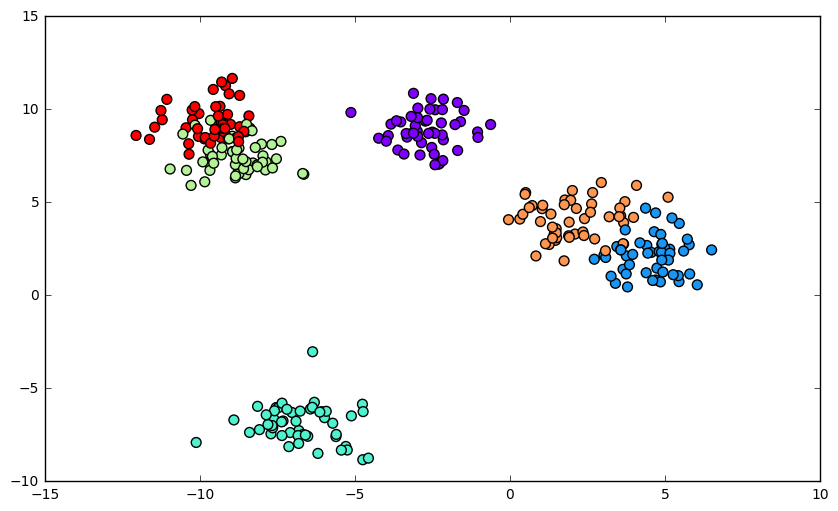

In [2]:
plt.figure(figsize=(10,6))
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=6,
                  random_state=42, cluster_std=1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

## Let's See this with a Single Decision Tree

In [3]:
def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None):
    estimator.fit(X, y)

    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10,6))
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='rainbow')
    plt.clim(y.min(), y.max())

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
    plt.axis('off')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    plt.clim(y.min(), y.max())
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i < 0:
            return

        tree = estimator.tree_
        
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())
        
def plot_tree_interactive(X, y):
    from sklearn.tree import DecisionTreeClassifier

    def interactive_tree(depth=1):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    from IPython.html.widgets import interact
    return interact(interactive_tree, depth=[1, 10])

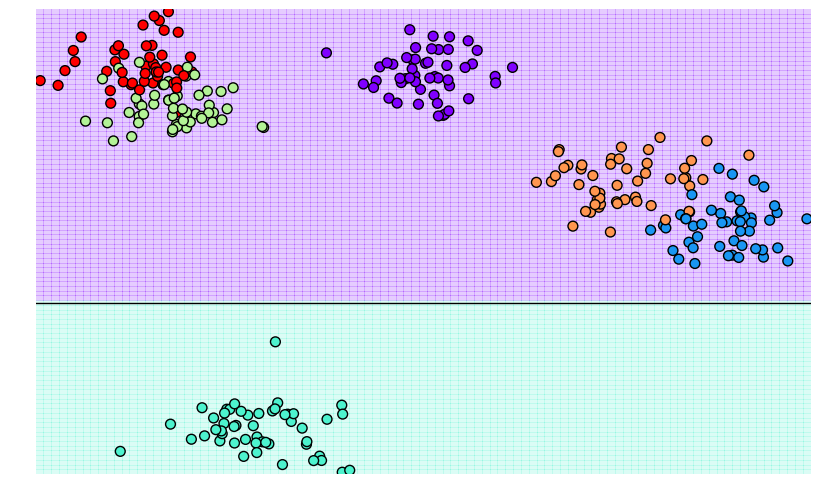

In [4]:
plot_tree_interactive(X, y);

## Let's See What The Boundaries Look Like for Different Seeds

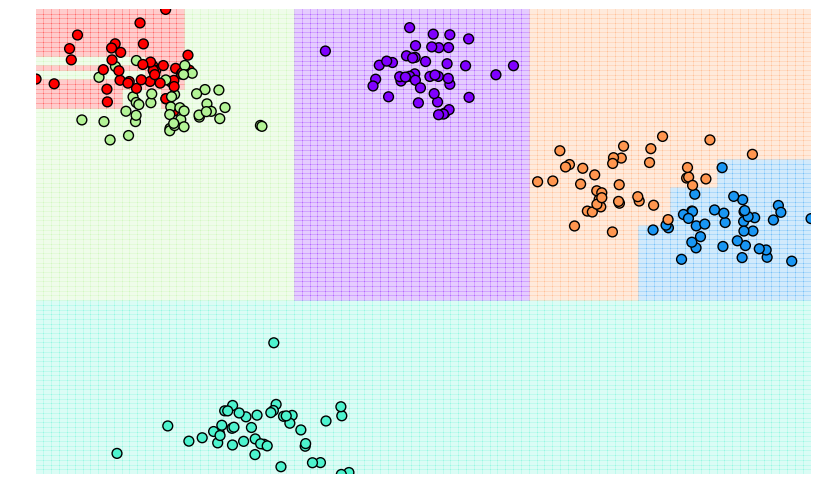

In [11]:

def fit_randomized_tree(random_state=0):
    X, y = make_blobs(n_samples=300, centers=6,
                      random_state=42, cluster_std=1)
    clf = DecisionTreeClassifier(max_depth=15)
    
    rng = np.random.RandomState(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)
    visualize_tree(clf, X[i[:250]], y[i[:250]], boundaries=False,
                   xlim=(X[:, 0].min(), X[:, 0].max()),
                   ylim=(X[:, 1].min(), X[:, 1].max()))
from IPython.html.widgets import interact
interact(fit_randomized_tree, random_state=[0, 100]); 


## Exercise: 

- Take the code from the cell above and impelement the same thing as above, but use a Random Forest Classifier
- Change the n_estimators parameter from something small (lise 5) to something large (like 1000)
- What is the effect on the boundaries when you do this?

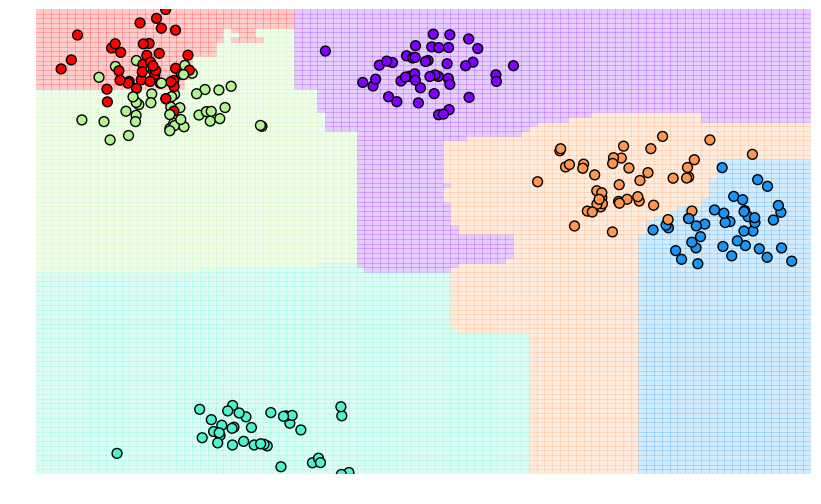

In [24]:
from sklearn.ensemble import RandomForestClassifier
def fit_forest(random_state=0):
    X, y = make_blobs(n_samples=300, centers=6,
                      random_state=42, cluster_std=1)
    clf = RandomForestClassifier(max_depth=5, n_estimators=1000)
    
    rng = np.random.RandomState(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)
    visualize_tree(clf, X[i[:250]], y[i[:250]], boundaries=False,
                   xlim=(X[:, 0].min(), X[:, 0].max()),
                   ylim=(X[:, 1].min(), X[:, 1].max()))
from IPython.html.widgets import interact
interact(fit_forest, random_state=[0, 100]); 



## Two types of ensemble techniques
<br>
**Averaging Methods**
> In averaging methods, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced. _We'll discuss this today._

**Boosting Methods**
> The other family of ensemble methods are boosting methods, where base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble. _We will discuss these in a future lecture._

## Bagging

Bagging or bootstrap aggregating is a method that involves manipulating the training set by resampling. We learn $k$ base classifiers on $k$ different samples of training data. These samples are independently created by resampling the training data using uniform weights (e.g. a uniform sampling distribution). 

In other words each model in the ensemble votes with equal weight. In order to promote model variance, bagging trains each model in the ensemble using a randomly drawn subset of the training set. As an example, the random forest algorithm combines random decision trees with bagging to achieve very high classification accuracy.

|Original|1|2|3|4|5|6|7|8|
|----|----|----|----|----|----|----|----|----|
|Training set 1|2|7|8|3|7|6|3|1|
|Training set 2|7|8|5|6|4|2|7|1|
|Training set 3|3|6|2|7|5|6|2|2|
|Training set 4|4|5|1|4|6|4|3|8|

Given a standard training set $D$ of size $n$, bagging generates $m$ new training sets $D_i$, each of size $n'$, by sampling from $D$ uniformly and with replacement. By sampling with replacement, some observations may be repeated in each $D_i$. The $m$ models are fitted using the above $m$ samples and combined by averaging the output (for regression) or voting (for classification).

## Bagging, Cont.

Since each sample of training data is equally likely, bagging is not very susceptible to overfitting with noisy data.

As they provide a way to reduce overfitting, bagging methods work best with strong and complex models (e.g., fully developed decision trees), in contrast with boosting methods which usually work best with weak models (e.g., shallow decision trees).

## Bagging Classifier in Scikit Learn

In scikit-learn, bagging methods are offered as a unified BaggingClassifier meta-estimator (resp. BaggingRegressor), taking as input a user-specified base estimator along with parameters specifying the strategy to draw random subsets. 

## Let's See it Now with Our Tree Example

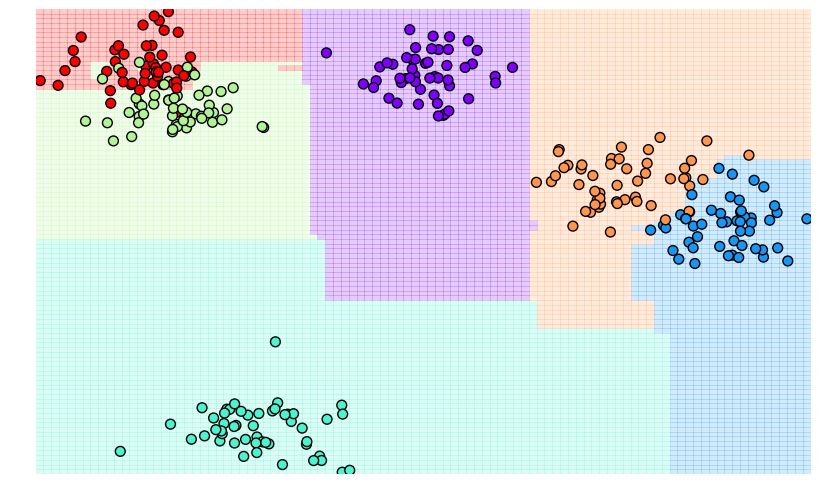

In [25]:
# with bagging
from sklearn.ensemble import BaggingClassifier
clf = DecisionTreeClassifier(max_depth=15)
bagger = BaggingClassifier(clf, max_samples=1.0)
visualize_tree(bagger, X, y, boundaries=False);

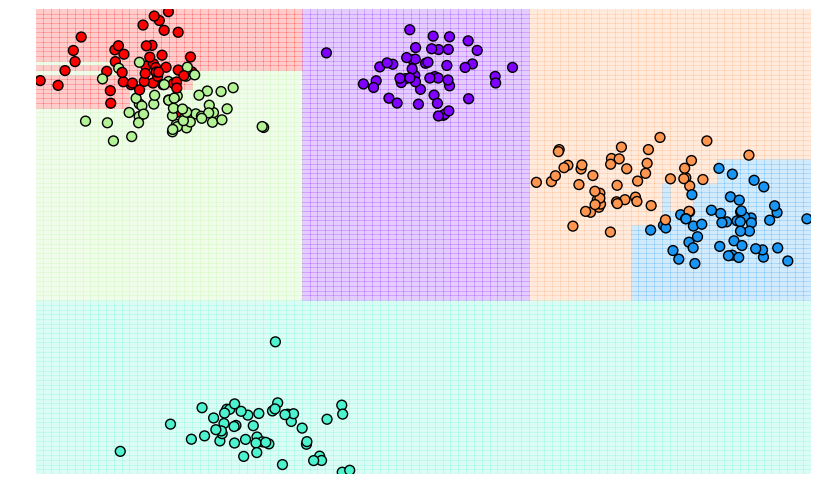

In [26]:
# without
clf = DecisionTreeClassifier(max_depth=15)
visualize_tree(clf, X, y, boundaries=False);

## Let's Now Take a Look at the CrossVal Score

In [27]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import BaggingClassifier

clf = DecisionTreeClassifier()
bagger = BaggingClassifier(clf)

print "DT Score:\t", cross_val_score(clf, X, y, cv=10, n_jobs=-1).mean()
print "Bagging Score:\t", cross_val_score(bagger, X, y, cv=10, n_jobs=-1).mean()

DT Score:	0.906666666667
Bagging Score:	0.916666666667


## Check: Does bagging interfere with grid search? Are we leaking data and thus faking the cross val score?

## Exercise:
<br>
Part I:<br>
The BaggingClassifier meta-estimator has several parameters.
<br>
In pairs, look at the documentation for a detailed description of each and find out what max_samples and max_features do.
<br><br>
Part II:
Implement knn on the data (X,y) then use the BaggingClassifier with knn and run cross_val_score - which performs best?

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn_X, knn_y = make_blobs(n_samples=300, centers=6,
                         random_state=42, cluster_std=1)
knn_clf = KNeighborsClassifier()
bagger_clf = BaggingClassifier(knn_clf)

print "Knn Score:\t", cross_val_score(knn_X, knn_y, cv=10, n_jobs=-1).mean()
print "Bagging Score:\t", cross_val_score(bagger_clf, knn_X, knn_y, cv=10, n_jobs=-1).mean()



Knn Score:	

TypeError: estimator should a be an estimator implementing 'fit' method, array([[ -0.62301172,   9.18886394],
       [-11.06689636,  10.54195109],
       [ -2.30033403,   7.054616  ],
       [  4.41641605,   2.68717018],
       [ -3.83738367,   9.21114736],
       [  1.90997219,   3.94048196],
       [  1.42990631,   3.29746079],
       [ -8.7625232 ,   6.6463612 ],
       [  2.40636568,   4.12875681],
       [ -9.01123799,   9.19515166],
       [  3.7560214 ,   2.12689479],
       [ -2.52269485,   7.9565752 ],
       [  4.56277713,   2.31432166],
       [ -3.21125072,   8.68662398],
       [ -9.85818505,   8.41943333],
       [ -3.6155326 ,   7.8180795 ],
       [  4.7395302 ,   1.46969403],
       [  4.81305976,   2.35848706],
       [-11.45910204,   9.04668356],
       [ -2.90130578,   7.55077118],
       [  5.78270165,   2.72510272],
       [  5.461939  ,   3.86996267],
       [ -2.85191214,   8.21200886],
       [-10.04767101,   8.54835267],
       [  2.09966854,   3.30016735],
       [ -2.26723535,   7.10100588],
       [ -8.01291141,   8.13703255],
       [ -9.82725816,   8.49063338],
       [  3.66519717,   2.76025429],
       [ -9.66054815,   7.56721013],
       [  5.10118104,   5.28102647],
       [ -8.55077017,   8.88818064],
       [-10.44872348,   9.0136415 ],
       [  3.57345221,   4.27712619],
       [ -8.14051115,  -5.96224765],
       [  3.79308512,   0.45832246],
       [  4.89976163,   2.75499256],
       [ -9.24981371,   8.98290913],
       [ -8.9528676 ,   8.56133923],
       [ -7.54141366,  -6.02767626],
       [  2.72110762,   1.94665581],
       [  5.1549141 ,   2.48695563],
       [ -6.43580776,  -6.10547554],
       [  4.08304816,   5.9167924 ],
       [ -9.50172033,   9.24251981],
       [  1.89438264,   3.20591112],
       [ -2.54502366,  10.57892978],
       [ -6.80982511,  -7.26542319],
       [-10.03260337,   9.77549754],
       [ -4.74659382,  -8.83219739],
       [  1.03657419,   4.66549807],
       [ -9.17487521,  11.27499286],
       [ -9.66382495,   7.00213707],
       [  3.66726795,   3.91241552],
       [ -3.31769123,   8.51252908],
       [  0.83904172,   2.12221938],
       [  3.0323956 ,   2.15780354],
       [  3.64934251,   1.40687195],
       [  0.50710917,   5.52832582],
       [ -7.03141229,  -6.29179239],
       [ -2.16557933,   7.25124597],
       [  1.32257473,   4.37543147],
       [ -9.32858761,   8.49388042],
       [ -8.95552825,  11.6688899 ],
       [ -6.06676507,  -6.25048075],
       [  5.60325497,   2.38595061],
       [-10.2864121 ,   5.91605914],
       [ -8.5156092 ,   6.49629197],
       [ -8.52742019,   8.79887913],
       [ -7.46899195,  -6.0305075 ],
       [  3.7204546 ,   3.52310409],
       [ -9.84434514,   6.1093343 ],
       [  0.3189178 ,   4.10590386],
       [ -9.35269556,  10.16906224],
       [  1.77333609,   5.13302251],
       [ -2.21307735,   9.2753414 ],
       [ -9.6780496 ,   6.72413027],
       [  1.46865093,   2.96357366],
       [ -8.8313215 ,   8.47603172],
       [ -3.11090424,  10.86656431],
       [ -5.29361038,  -8.11792509],
       [ -3.4172217 ,   7.60198243],
       [ -2.1475616 ,   8.36916637],
       [ -9.21716424,   8.79421186],
       [ -2.98837186,   8.82862715],
       [ -9.30936606,   7.55557285],
       [-10.55146229,   8.67739529],
       [ -6.30873668,  -5.74454395],
       [  3.44857534,   2.62972329],
       [ -8.42052805,   9.65261789],
       [ -8.71718541,   9.07217351],
       [ -8.94971766,   7.73667698],
       [ -5.12894273,   9.83618863],
       [ -8.71870419,  10.7538349 ],
       [ -3.03895783,   9.52755356],
       [ -2.41212007,   9.98293112],
       [ -8.38709619,   8.99012167],
       [  3.20159742,   4.22897004],
       [  3.40292813,   0.65271307],
       [-10.24014622,   9.44559571],
       [-10.43275542,   6.72414789],
       [  0.71783073,   4.8311241 ],
       [  5.72293008,   3.02697174],
       [ -5.98002732,  -6.57281007],
       [  6.04267315,   0.57131862],
       [ -2.17793419,   9.98983126],
       [ -4.23411546,   8.4519986 ],
       [ -4.56496862,  -8.74737479],
       [ -2.18511365,   8.62920385],
       [  3.95985411,   2.20542338],
       [ -8.49657178,   9.19969375],
       [ -9.48897781,  10.14958417],
       [ -7.35155906,  -5.791159  ],
       [  5.45339605,   0.74230537],
       [ -1.59379551,   9.34303724],
       [ -3.05358035,   9.12520872],
       [ -1.68665271,   7.79344248],
       [ -5.11417295,  -6.47512788],
       [  0.48818606,   5.43912838],
       [  1.26594949,   2.73919785],
       [ -9.73674243,   7.81544209],
       [ -7.86320802,   7.17646553],
       [ -7.38718415,   8.28279374],
       [ -6.64852482,   6.51522463],
       [  5.22673593,   4.16362531],
       [ -7.68021688,   8.11518561],
       [ -9.65438991,   8.18718084],
       [-11.62643465,   8.39011073],
       [  0.41585391,   4.36491519],
       [ -1.4781981 ,   9.94556625],
       [ -6.193367  ,  -8.49282546],
       [  1.74724854,   1.85953039],
       [  3.26220947,   1.03534464],
       [  4.70010905,   4.4364118 ],
       [ -2.72886951,   9.3713987 ],
       [ -3.52202874,   9.32853346],
       [ -2.96983639,  10.07140835],
       [ -8.0799236 ,  -7.21461083],
       [ -5.24721589,  -8.31025097],
       [-10.36209931,   8.15354234],
       [ -3.92456837,   8.59364081],
       [  2.14259587,   4.67589039],
       [ -2.97261532,   8.54855637],
       [  3.75036441,   1.1573594 ],
       [  3.70944187,   5.04309131],
       [ -2.41743685,   7.02671721],
       [ -9.31785329,   9.34795893],
       [ -5.61271604,  -7.58777906],
       [ -7.60999382,  -6.663651  ],
       [ -7.7086222 ,  -7.44029063],
       [  4.65288073,   3.42670376],
       [ -8.29123038,   7.12133026],
       [ -8.15637479,   7.01325616],
       [  4.93295131,   1.25881827],
       [ -1.04354885,   8.78850983],
       [-10.25093387,   9.96879571],
       [ -7.08774944,  -7.37311053],
       [  2.66767618,   5.53008311],
       [ -2.50408417,   8.77969899],
       [ -7.3545725 ,  -7.53343883],
       [ -8.74065166,   6.55051313],
       [  2.35461425,   3.41296502],
       [-11.21585255,   9.44628199],
       [  4.69808755,   0.83019939],
       [ -2.42215055,   8.71527878],
       [ -7.96600712,   7.50686492],
       [  1.14668198,   2.77865182],
       [ -8.75890453,   7.18706173],
       [  4.9976662 ,   2.53395421],
       [ -9.26138274,   9.17909651],
       [ -8.85734396,   6.32099355],
       [  4.44751787,   2.27471703],
       [  4.89037169,   2.31961789],
       [  4.86733877,   3.28031244],
       [  5.43091078,   1.06378223],
       [  3.85662554,   1.65110817],
       [-10.15856096,   9.15498168],
       [  4.85397258,   0.72743091],
       [ -6.6805675 ,  -7.48032647],
       [ -8.94708791,   7.72523464],
       [-10.96222348,   6.79776789],
       [ -7.88790392,   6.74661926],
       [  5.26554618,   1.11601213],
       [ -8.39899716,  -7.36434367],
       [ -8.85057453,   6.42626854],
       [ -9.29853526,  11.47359784],
       [ -3.6601912 ,   9.38998415],
       [  1.50843332,   3.10223803],
       [ -7.31967168,  -6.74936902],
       [ -5.92562543,  -6.22871834],
       [ -9.25070745,   8.98632008],
       [ -8.74133179,   7.91867994],
       [ -2.44166942,   7.58953794],
       [ -7.13219534,  -8.12789278],
       [ -5.4383539 ,  -8.31597174],
       [  2.63646693,   4.91895927],
       [  1.49179909,   3.58563332],
       [ -8.4253963 ,   6.75979836],
       [  2.01432759,   5.64139569],
       [ -6.83405535,  -7.53170994],
       [ -7.65888764,   6.85434726],
       [ -8.85684089,   7.03486428],
       [ -8.90476978,  -6.69365528],
       [  5.79847442,   1.15248737],
       [  1.91526987,   3.12620923],
       [ -2.62484591,   8.71318243],
       [ -3.98771961,   8.29444192],
       [ -8.59336119,   6.81657974],
       [ -6.52261171,  -7.57301919],
       [ -2.58120774,  10.01781903],
       [ -7.98066813,   7.16358439],
       [  3.98702537,   4.19671511],
       [  0.62373266,   4.72442079],
       [ -9.65654844,   9.41591019],
       [ -2.14780202,  10.55232269],
       [  3.08921541,   2.04173266],
       [  3.08072472,   2.40271207],
       [ -6.6851453 ,   6.55617535],
       [ -4.75747099,  -5.84764433],
       [-10.35156927,   7.59331494],
       [  3.65091578,   2.7813501 ],
       [  1.95962114,   5.11659388],
       [ -9.10933029,   9.73185915],
       [  1.49204262,   3.36857872],
       [-10.07591634,   8.96563886],
       [  5.1618204 ,   2.27015436],
       [  1.37572735,   3.07990355],
       [ -9.40644386,   9.64641763],
       [ -9.59746042,   7.4739167 ],
       [  2.94847778,   6.0708682 ],
       [  2.38889848,   3.22157177],
       [  4.375222  ,   4.69333885],
       [ -6.37463991,  -6.0143544 ],
       [ -6.13233359,  -6.26973933],
       [  1.37165767,   3.67432617],
       [ -7.65245241,  -7.1169282 ],
       [  4.91656964,   2.80035293],
       [  4.39449072,   1.21943352],
       [ -9.08739293,   8.4206418 ],
       [ -2.67048333,   9.41833699],
       [  1.7528934 ,   4.87899381],
       [ -4.7356831 ,  -6.24619057],
       [ -8.5141614 ,   7.19337986],
       [-12.05995461,   8.60130179],
       [ -5.6019623 ,  -7.47168098],
       [  2.5988572 ,   4.47270171],
       [ -9.05850594,  10.83976566],
       [ -9.56989173,  11.07463436],
       [ -8.31898124,   8.85626183],
       [ -8.21420794,   7.95186842],
       [  3.56898634,   2.4556421 ],
       [  0.98505408,   3.97111288],
       [ -8.83308406,   7.37050351],
       [ -8.61423527,   7.33611532],
       [ -9.28839323,   7.94637285],
       [ -8.5820173 ,   8.82130517],
       [ -9.05600896,   8.42229977],
       [ -9.19385797,   8.97721256],
       [ -8.14818376,   6.92230244],
       [ -9.53978849,   8.56724693],
       [-10.12089453,  -7.90449723],
       [ -1.77073104,   9.18565441],
       [ -8.7579743 ,   8.54211322],
       [  6.50565335,   2.4470026 ],
       [  5.11311646,   1.90034077],
       [ -3.34841515,   8.70507375],
       [  3.54542431,   4.7003616 ],
       [  3.57757512,   2.44676211],
       [ -7.53284895,   7.34452676],
       [ -7.67214793,  -6.99484603],
       [  2.73391511,   3.03680946],
       [ -6.76610985,  -6.21797892],
       [ -6.90052879,  -6.76278221],
       [  4.60516707,   0.80449165],
       [ -2.97867201,   9.55684617],
       [ -8.81381758,   7.82152121],
       [ -6.81534717,  -7.95785437],
       [ -6.3645795 ,  -3.0273781 ],
       [-11.2577154 ,   9.94155724],
       [ -8.752618  ,   8.26849019],
       [  3.52465729,   4.23554634],
       [ -1.6966718 ,  10.37052616],
       [  4.89742923,   1.89872377],
       [  4.19336388,   2.82956848],
       [ -7.36499074,  -6.79823545],
       [ -7.80655766,  -6.93963495],
       [ -5.71646344,  -6.86987653],
       [ -9.55677198,   7.11007576],
       [ -9.51674388,   8.9205396 ],
       [ -7.5949309 ,  -6.20051184],
       [  1.05737677,   4.84750302],
       [ -7.19489644,  -6.12114037],
       [ -6.59863532,  -7.50280911],
       [ -0.04514187,   4.07233152],
       [ -3.18611962,   9.62596242],
       [ -9.90594819,   7.18114343],
       [ -7.86113584,  -6.41800612],
       [ -1.03130358,   8.49601591],
       [-10.16508144,  10.15358827],
       [ -3.10983631,   8.72259238]]) was passed

## Independent Practice

Take a dataset of your choice and practice comparing the score of a base classifier with the bagging classifier. Explore also the effect of changing one or more parameters.

## Conclusion

In this lecture, we've seen:
- How aggregating independent true signals leads to improved perfomance
- How using ensembles can improve our models by reducing variance
- How bagging works
- How to implement bagging in sk-learn


## Additional Materials
[Galton](https://en.wikipedia.org/wiki/Francis_Galton)<br>
[Galton visits the Fair](http://wisdomofcrowds.blogspot.com/2009/12/introduction-part-i.html)
[Penelope](http://www.npr.org/sections/money/2015/08/07/429720443/17-205-people-guessed-the-weight-of-a-cow-heres-how-they-did)<br>
[Wisdom of the crowds](https://en.wikipedia.org/wiki/The_Wisdom_of_Crowds)<br>
[The Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize)